# Importando los paquetes que vamos a usar

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from pprint import pprint
import imblearn
import os

# Todas las piezas concretas que usamos de sklearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import LocalOutlierFactor

# Todas las piezas concretas que vamos a usar de imbalanced-learn
from imblearn.combine import SMOTETomek

# Catboost
from catboost import Pool, CatBoostClassifier

# Fijamos una semilla aleatoria

In [2]:
RANDOM_SEED = 123456789

np.random.seed(RANDOM_SEED)

# Funciones comunes a todo el código

## Funciones para evaluar el ajuste

In [3]:
def calculate_roc_auc(true_labels_prob: np.array, predicted_labels_prob: np.array) -> float:
    """
    Calcula el area bajo la curva ROC, dadas las etiquetas verdaderas y las
    etiqeutas predichas por un modelo
    
    Las listas de etiquetas deben ser etiquetas probabilisticas
    """
    return roc_auc_score(true_labels_prob, predicted_labels_prob, average = "macro")
    
def calculate_accuracy(true_labels: np.array, predicted_labels: np.array) -> float:
    """
    Calcula el accuracy, dadas las etiquetas verdaderas y las
    etiqeutas predichas por un modelo
    """
    return accuracy_score(true_labels, predicted_labels)
    
def evaluate_model(model, x_train: np.ndarray, y_train: np.array, x_test: np.ndarray, y_test: np.array) -> dict:
    """
    Evalua, usando distintas metricas, el modelo que hemos entrenado
    
    Devuelve un diccionario con todas las metricas calculadas con el modelo
    """
    
    # Diccionario en el que vamos a almacenar todas las metricas
    metrics = dict()
    
    # Empezamos usando el modelo para realizar las predicciones+
    # Usamos predicciones probabilisticas pues estas son fundamentales para
    # la competicion
    # Hacemos [:, 1] porque predict_proba da dos arrays, y el que usamos para el
    # roc_auc es el segundo
    train_predicted_labels_prob = np.array(model.predict_proba(x_train))
    test_predicted_labels_prob = np.array(model.predict_proba(x_test))
    
    # Extraemos la columna positiva para cada salida
    # Necesitamos hacer esto para poder calcular el roc_auc
    train_predicted_labels_prob = np.transpose([pred[:, 1] for pred in train_predicted_labels_prob])
    test_predicted_labels_prob = np.transpose([pred[:, 1] for pred in test_predicted_labels_prob])
    
    # Tomamos ahora las etiqeutas sin probabilidad
    train_predicted_labels= np.array(model.predict(x_train))
    test_predicted_labels = np.array(model.predict(x_test))
               
    # Tomamos las areas bajo la curva ROC
    metrics["train_roc_auc"] = calculate_roc_auc(y_train, train_predicted_labels_prob)
    metrics["test_roc_auc"] = calculate_roc_auc(y_test, test_predicted_labels_prob)
    
    # Tomamos las metricas de accuracy
    metrics["train_acc"] = calculate_accuracy(y_train, train_predicted_labels)
    metrics["test_acc"] = calculate_accuracy(y_test, test_predicted_labels)
    
    # Devolvemos las metricas en formato diccionario, que nos va a ser comodo para
    # pasarlas a tablas y para mostrar muchas metricas simultaneamente
    return metrics

## Funciones para hacer la submission

In [4]:
def generate_submission(model, x_test: np.ndarray):
    """
    Dado un conjunto de test, genera las etiquetas que subiremos a la plataforma
    """
    
    prob_labels = model.predict_proba(x_test)
    return prob_labels

## Funciones para manipular `dataframes`

In [5]:
def dataframe_filter_object_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Dado un dataframe, devolvemos una COPIA de este en el que solo
    nos quedamos con las columnas numericas
    
    @param df dataframe que se filtra. No se modifica
    @return new_df dataframe copiado y que se ha filtrado
    """
    
    # No modificamos el dataframe que se pasa como parametro
    new_df = df.copy()
    
    for column, column_type in zip(new_df.columns, new_df.dtypes):
        if column_type == "object":
            new_df = new_df.drop(columns = [column])
                        
    return new_df

# Parámetros globales del Notebook

In [6]:
# Variable que se usa para comprobar si estamos corriendo el notebook en local
# o en Google Colab (para mayor rapidez en los experimentos)
RUNNING_ENV = "local"

# PATH base 
BASE_PATH = "../" if RUNNING_ENV == "local" else "/content/drive/MyDrive/Colab Notebooks/"

# Fichero en el que vamos a guardar la prediccion actual
# Es un fichero temporal, porque luego tendremos que nombrarlo y guardarlo en
# el archivo enumerado correspondiente
SUBMISSION_CSV = os.path.join(BASE_PATH, "tmp_submission.csv")

# Ficheros en los que tenemos almacenados los datos
TRAINING_FEATURES_FILE = os.path.join(BASE_PATH, "data/training_set_features.csv")
TRAINING_LABELS_FILE = os.path.join(BASE_PATH, "data/training_set_labels.csv")
TEST_FEATURES_FILE = os.path.join(BASE_PATH, "data/test_set_features.csv")
SUBMISSION_FORMAT_FILE = os.path.join(BASE_PATH, "data/submission_format.csv")

# Si hacemos que esta variable sea True, evitamos realizar todos los computos 
# asociados a cross validation
SKIP_CROSS_VALIDATION = True

# Para evitar que tener que re-calcular el procesado de datos. Tenemos archivos
# en los que guardamos los datos pre-procesados y que podemos emplear
# Cuando es False, re-calculamos el procesado de datos y ademas actualizamos los 
# valores cacheados
USE_CACHED_PREPROCESSED_DATA = True

# Ficheros en los que guardamos el procesado de los datos
TRAIN_FEATURES_CACHED_FILE = os.path.join(BASE_PATH, "data/training_set_features_cached.npy")
TRAIN_LABELS_CACHED_FILE = os.path.join(BASE_PATH, "data/training_set_labels_cached.npy")
VALIDATION_FEATURES_CACHED_FILE = os.path.join(BASE_PATH, "data/validation_set_features_cached.npy")
VALIDATION_LABELS_CACHED_FILE = os.path.join(BASE_PATH, "data/validation_set_labels_cached.npy")
TEST_FEATURES_CACHED_FILE = os.path.join(BASE_PATH, "data/test_set_features_cached.npy")

# Cargamos los datos del problema

In [7]:
# Cargamos los datos en google drive si estamos usando Google Colab
if RUNNING_ENV == "remote":
    from google.colab import drive
    drive.mount('/content/drive')

In [8]:
# Cargamos los dos ficheros csv con los datos de entrenamiento
base_path = ".."
df = pd.read_csv(TRAINING_FEATURES_FILE)
df_labels = pd.read_csv(TRAINING_LABELS_FILE)

# Juntamos ambos dataframes en uno solo
df = pd.concat([df, df_labels], axis = 1)
df_labels = None

# Tomamos los datos de test
df_test = pd.read_csv(TEST_FEATURES_FILE)

## Coloco los nombres de ciertas columnas en variables

Esto para que sea más cómodo trabajar con ciertas columnas principales en el problema

In [9]:
h1n1_vac = "h1n1_vaccine"
seas_vac = "seasonal_vaccine"

# Análisis Exploratorio de datos

In [10]:
df.describe()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,respondent_id,h1n1_vaccine,seasonal_vaccine
count,26707.000000,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,...,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000,26707.000000,26707.000000,26707.000000
mean,13353.000000,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,...,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583,13353.000000,0.212454,0.465608
std,7709.791156,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,...,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173,7709.791156,0.409052,0.498825
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6676.500000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,...,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000,6676.500000,0.000000,0.000000
50%,13353.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,...,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000,13353.000000,0.000000,0.000000
75%,20029.500000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,...,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000,20029.500000,0.000000,1.000000
max,26706.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000,26706.000000,1.000000,1.000000


In [11]:
# TODO -- hacer el conteo de NAN values

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [12]:
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,1,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,2,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,3,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,4,0,0


In [13]:
df.dtypes

respondent_id                    int64
h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                      

## Mostramos el balanceo de las dos clases que queremos predecir

Vacuna h1n1


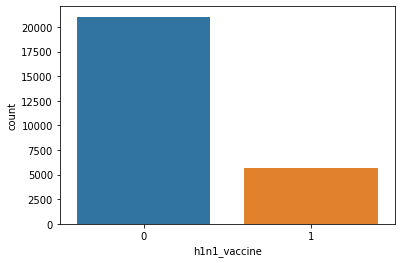

Vacuna seasonal


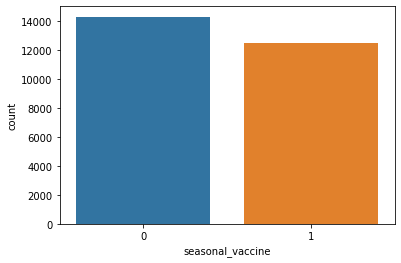

In [14]:
print("Vacuna h1n1")
sns.countplot(data = df, x = h1n1_vac)
plt.show()

print("Vacuna seasonal")
sns.countplot(data = df, x = seas_vac)
plt.show()

## Mostramos el pairplot de todas las variables

In [15]:
# TODO -- implementar

# Pre-procesado de los datos

## Borrado de la columna de identificación

Esta columna no va a ser útil para nuestros modelos de *machine learning*. Por tanto, borramos esta columna del `dataframe`:

In [16]:
# Comprobamos si queremos o no saltar el procesado de los datos
if USE_CACHED_PREPROCESSED_DATA is False:

    # Borramos esta columna para el training
    df = df.drop(['respondent_id'], axis=1)
    pprint(df.head())

    # Borramos esa columna tambien para el test
    df_test = df_test.drop(['respondent_id'], axis=1)

## Combinamos las dos variables de salida en una única

Hacemos esto para, más adelante, poder separar en training / validation estratificando por las dos variables de salida a la vez

In [17]:
# Comprobamos si queremos o no saltar el procesado de los datos
if USE_CACHED_PREPROCESSED_DATA is False:

    combined = "combined"

    def combine_two_objective_functions(h1n1, seasonal):
        """
        Funcion que toma los valores de las dos variables objetivo, y las combina en una sola
        """

        mapping = dict()
        mapping[0, 0] = 0
        mapping[0, 1] = 1
        mapping[1, 0] = 2
        mapping[1, 1] = 3

        return mapping[h1n1, seasonal]

    df[combined] = df.apply(lambda row: combine_two_objective_functions(row[h1n1_vac], row[seas_vac]), axis = 1)

## Separamos el dataframe en training y validation

Separamos en training y validation. validation y no test porque el test es el que nos da la competición. Además, validation porque vamos a usar la informaión sobre este conjunto para ajustar nuestros modelos.

In [18]:
# Comprobamos si queremos o no saltar el procesado de los datos
if USE_CACHED_PREPROCESSED_DATA is False:
    train, validation = train_test_split(df, test_size=0.2, stratify = df[combined])

## Borramos la variable combinada

Ya ha cumplido su propósito: ser la variable de estratificación. Así que la borramos pues no vamos a usar más esta variable

In [19]:
# Comprobamos si queremos o no saltar el procesado de los datos
if USE_CACHED_PREPROCESSED_DATA is False:

    train = train.drop(columns = [combined])
    validation = validation.drop(columns = [combined])

## Separamos el dataframe en x, y arrays

In [20]:
# Comprobamos si queremos o no saltar el procesado de los datos
if USE_CACHED_PREPROCESSED_DATA is False:

    all_columns = train.columns
    train_columns = list(all_columns)
    train_columns.remove(h1n1_vac)
    train_columns.remove(seas_vac)

    # Separamos segun las columnas del dataframe
    x_train, y_train = train[train_columns], train[[h1n1_vac, seas_vac]]
    x_validation, y_validation = validation[train_columns], validation[[h1n1_vac, seas_vac]]

    # Lo convertimos a arrays de numpy
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_validation, y_validation = np.array(x_validation), np.array(y_validation)
    x_test = np.array(df_test)

## Pasamos todas las variables a variables numéricas

Vamos a usar modelos que solo trabajan con variables numéricas, así que convertimos todas las columnas a numéricas. Para ello, recorremos los tipos de las columnas. Si nos encontramos con una columna de tipo `object`, la convertimos a numérica. Usamos one hot encoding para ello.

In [21]:
# Comprobamos si queremos o no saltar el procesado de los datos
if USE_CACHED_PREPROCESSED_DATA is False:

    # Aprendemos el enconding sobre el conjunto de entrenamiento
    encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
    encoder.fit(x_train)

    # Aplicamos dicha transformacion aprendida en entrenamiento
    # No estamos haciendo data snooping porque la transformacioon se aprende en 
    # entrenamiento y con ello se aplica sobre el resto de conjuntos
    x_train = encoder.transform(x_train)
    x_validation = encoder.transform(x_validation)
    x_test = encoder.transform(x_test)

## Imputación de los missing values

Notar que no usamos los datos de salida para realizar la imputación.

In [22]:
# Comprobamos si queremos o no saltar el procesado de los datos
if USE_CACHED_PREPROCESSED_DATA is False:

    print(f"Tamaño previo de entrenamiento: {x_train.shape}")
    print(f"Tamaño previo de test: {x_test.shape}")

    # Calculamos la imputacion para los valores perdidos
    # Imputamos usando el resto de variables
    imputer = IterativeImputer(random_state = RANDOM_SEED)
    imputer.fit(x_train)

    # Aplicamos la imputacion calculada sobre el conjunto de test sobre el resto
    # de conjuntos
    x_train = pd.DataFrame(imputer.transform(x_train))
    x_validation = pd.DataFrame(imputer.transform(x_validation))
    x_test = pd.DataFrame(imputer.transform(x_test))

    print(f"Tamaño posterior de entrenamiento: {x_train.shape}")
    print(f"Tamaño posterior de test: {x_test.shape}")

## Borrado de outliers

In [23]:
# Comprobamos si queremos o no saltar el procesado de los datos
if USE_CACHED_PREPROCESSED_DATA is False:

    # Tomamos el tamaño original del dataset, para ver cuantos ejemplos perdemos
    original = x_train.shape[0]
    print(f"Tamaño previo de entrenamiento: {x_train.shape}")

    # Definimos el clasificador que vamos a usar para detectar outliers
    clf = LocalOutlierFactor(n_neighbors=2)

    # Generamos una mascara con las filas detectadas como outlier
    yhat = clf.fit_predict(x_train)
    mask = yhat != -1

    # Nos quedamos solo con las filas que no son outliers
    x_train, y_train = x_train[mask], y_train[mask]

    # Calculamos el numero de ejemplos que hemos perdido
    left = x_train.shape[0]
    print(f"Tamaño posterior de entrenamiento: {x_train.shape}")
    print(f"Porcentaje del dataset que sobrevive: {(left) / original * 100}") 

## Normalizamos el dataset

In [24]:
# Comprobamos si queremos o no saltar el procesado de los datos
if USE_CACHED_PREPROCESSED_DATA is False:

    # Escalamos a media 0 y desviacion 1
    scaler = StandardScaler()

    # Aprendemos el escalado sobre el conjunto de entrenamiento
    scaler.fit(x_train)

    # Aplicamos el escalado aprendido en nuestros conjuntos de datos
    x_train = scaler.transform(x_train)
    x_validation = scaler.transform(x_validation)
    x_test = scaler.transform(x_test)

## Carga o actualización de la cache

Según el valor de la variable `USE_CACHED_PREPROCESSED_DATA`, cargamos los datos guardados en cache o actualizamos dicha cache.

In [25]:
# CARGAMOS VALORES DESDE CACHE
if USE_CACHED_PREPROCESSED_DATA is True:
    # Conjunto de entrenamiento
    x_train = np.load(TRAIN_FEATURES_CACHED_FILE)
    y_train = np.load(TRAIN_LABELS_CACHED_FILE)
    
    # Conjunto de validacion
    x_validation = np.load(VALIDATION_FEATURES_CACHED_FILE)
    y_validation = np.load(VALIDATION_LABELS_CACHED_FILE)
    
    # Conjunto de test
    x_test = np.load(TEST_FEATURES_CACHED_FILE)

In [26]:
# ACTUALIZAMOS LOS VALORES DE CACHE
if USE_CACHED_PREPROCESSED_DATA is False:
    # Conjunto de entrenamiento
    np.save(TRAIN_FEATURES_CACHED_FILE, x_train)
    np.save(TRAIN_LABELS_CACHED_FILE, y_train)
    
    # Conjunto de validacion
    np.save(VALIDATION_FEATURES_CACHED_FILE, x_validation)
    np.save(VALIDATION_LABELS_CACHED_FILE, y_validation)
    
    # Conjunto de test
    np.save(TEST_FEATURES_CACHED_FILE, x_test)

# Selección del modelo

- Probamos con distintos modelos, evaluándolos con Cross Validation
- Además, con Cross Validation, exploramos distintos parámetros para estos modelos, para comparar los modelos con los mejores parámetros que podamos encontrar

## Regresión Logística

In [27]:
# Valores para los hiperparametrosa del modelo
C_values = [0.05, 0.10, 0.15, 0.2, 0.25, 0.5, 0.6, 0.75, 1, 1.25, 1.5]

# Diccionario en el que guardamos parametros -> resultado
results = dict()

# Para precomputar la mejor combinacion de parametros
best_parameters = {
    "C": None,
}

best_auc = 0.0

# Para hacer 10 fold cross validation
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=RANDOM_SEED)

# Probamos con todas las combinaciones de parametros
for C in C_values:

    # Comprobacion de si queremos saltar cross validation
    if SKIP_CROSS_VALIDATION is True:
        break
    
    # Para ver el proceso de ejecucion
    print(f"Computando CV para {C}")

    # Definimos el clasificador, usando los parametros que movemos y fijando
    # el resto de parametros necesarios. 
    model = MultiOutputClassifier(
        estimator=LogisticRegression(penalty="l2", C=C, random_state = RANDOM_SEED)
    )

    # Aplicamos el algoritmo y evaluamos usando cross validation
    scores = cross_val_score(model, x_train, y_train, cv=cv, scoring='roc_auc')

    # Guardamos los resultados
    results[C, "mean"] = scores.mean()
    results[C, "std"] = scores.std()

    # Comprobamos si hemos mejorado los resultados
    if results[C, "mean"] > best_auc:
        best_auc = results[C, "mean"]
        best_parameters = {
            "C": C,
        }
        
        # Mostramos por pantalla la mejora
        print(f"\tMejor parametro encontrado: {best_parameters}, con auc: {best_auc}")

Mostramos los resultados:

In [28]:
print(f"Mejores valores de los parámetros: {best_parameters}")
print(f"Mejor valor de ROC AUC: {best_auc}")
print("")
print("Todos los parametros con sus resultados:")
pprint(results)

Mejores valores de los parámetros: {'C': None}
Mejor valor de ROC AUC: 0.0

Todos los parametros con sus resultados:
{}


## AdaBoost

In [29]:
# Valores para los hiperparametrosa del modelo
n_values = [25, 50, 75, 100, 150, 200]
learning_rate_values = [0.5, 0.75, 1.0, 1.25, 1.5]

# Diccionario en el que guardamos parametros -> resultado
results = dict()

# Para precomputar la mejor combinacion de parametros
best_parameters = {
    "n": None,
    "lr": None
}

best_auc = 0.0

# Para hacer 10 fold cross validation
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=RANDOM_SEED)

# Probamos con todas las combinaciones de parametros
for n in n_values:
    for lr in learning_rate_values:
    
        # Comprobacion de si queremos saltar cross validation
        if SKIP_CROSS_VALIDATION is True:
            break

        # Para ver el proceso de ejecucion
        print(f"Computando CV para {n}, {lr}")

        # Definimos el clasificador, usando los parametros que movemos y fijando
        # el resto de parametros necesarios. 
        model = MultiOutputClassifier(
            estimator=AdaBoostClassifier(n_estimators = n, learning_rate = lr, random_state = RANDOM_SEED)
        )

        # Aplicamos el algoritmo y evaluamos usando cross validation
        scores = cross_val_score(model, x_train, y_train, cv=cv, scoring='roc_auc')

        # Guardamos los resultados
        results[n, lr, "mean"] = scores.mean()
        results[n, lr, "std"] = scores.std()

        # Comprobamos si hemos mejorado los resultados
        if results[n, lr, "mean"] > best_auc:
            best_auc = results[n, lr, "mean"]
            best_parameters = {
                "n": n,
                "lr": lr
            }
            
            # Mostramos por pantalla la mejora
            print(f"\tMejor parametro encontrado: {best_parameters}, con auc: {best_auc}")

Mostramos los resultados:

In [30]:
print(f"Mejores valores de los parámetros: {best_parameters}")
print(f"Mejor valor de ROC AUC: {best_auc}")
print("")
print("Todos los parametros con sus resultados:")
pprint(results)

Mejores valores de los parámetros: {'n': None, 'lr': None}
Mejor valor de ROC AUC: 0.0

Todos los parametros con sus resultados:
{}


## CatBoost

In [31]:
# Valores para los hiperparametrosa del modelo
iterations_values = [5, 10, 15, 20]
learning_rate_values = [0.5, 0.75, 1.0, 1.25, 1.5]
depth_values = [1, 2, 3, 4]

# Diccionario en el que guardamos parametros -> resultado
results = dict()

# Para precomputar la mejor combinacion de parametros
best_parameters = {
    "iterations": None,
    "lr": None,
    "depth": None,
}

best_auc = 0.0

# Para hacer 10 fold cross validation
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=RANDOM_SEED)

# Probamos con todas las combinaciones de parametros
for iterations in iterations_values:
    for lr in learning_rate_values:
        for depth in depth_values:
    
            # Comprobacion de si queremos saltar cross validation
            if SKIP_CROSS_VALIDATION is True:
                break

            # Para ver el proceso de ejecucion
            print(f"Computando CV para {iterations}, {lr}, {depth}")

            # Definimos el clasificador, usando los parametros que movemos y fijando
            # el resto de parametros necesarios. 
            model = MultiOutputClassifier( 
                    estimator = CatBoostClassifier(
                    iterations=iterations,
                    learning_rate=lr,
                    depth=depth,
            ))

            # Aplicamos el algoritmo y evaluamos usando cross validation
            scores = cross_val_score(model, x_train, y_train, cv=cv, scoring='roc_auc')

            # Guardamos los resultados
            results[iterations, lr, depth, "mean"] = scores.mean()
            results[iterations, lr, depth, "std"] = scores.std()

            # Comprobamos si hemos mejorado los resultados
            if results[iterations, lr, depth, "mean"] > best_auc:
                best_auc = results[iterations, lr, depth, "mean"]
                best_parameters = {
                    "iterations": n,
                    "lr": lr,
                    "depth": depth
                }
                
                # Mostramos por pantalla la mejora
                print(f"\tMejor parametro encontrado: {best_parameters}, con auc: {best_auc}")

Mostramos los resultados:

In [32]:
print(f"Mejores valores de los parámetros: {best_parameters}")
print(f"Mejor valor de ROC AUC: {best_auc}")
print("")
print("Todos los parametros con sus resultados:")
pprint(results)

Mejores valores de los parámetros: {'iterations': None, 'lr': None, 'depth': None}
Mejor valor de ROC AUC: 0.0

Todos los parametros con sus resultados:
{}


# Ajuste del modelo

Tenemos un modelo que ajustar según el valor de la variable combinada:

In [33]:
# TODO -- borrar este codigo
#model = MultiOutputClassifier(
#    estimator=AdaBoostClassifier(n_estimators = 200, learning_rate = 0.75, random_state = RANDOM_SEED)
#)
model = MultiOutputClassifier( 
        estimator = CatBoostClassifier(
        iterations=20,
        learning_rate=1,
        depth=2,
))

model.fit(x_train, y_train)

0:	learn: 0.4253246	total: 49.7ms	remaining: 944ms
1:	learn: 0.3924350	total: 55.5ms	remaining: 500ms
2:	learn: 0.3711217	total: 59.1ms	remaining: 335ms
3:	learn: 0.3674732	total: 63.1ms	remaining: 252ms
4:	learn: 0.3645652	total: 67.9ms	remaining: 204ms
5:	learn: 0.3618202	total: 73.1ms	remaining: 171ms
6:	learn: 0.3599510	total: 75.6ms	remaining: 140ms
7:	learn: 0.3576854	total: 78ms	remaining: 117ms
8:	learn: 0.3565562	total: 80.2ms	remaining: 98ms
9:	learn: 0.3549815	total: 83.8ms	remaining: 83.8ms
10:	learn: 0.3538591	total: 86.8ms	remaining: 71.1ms
11:	learn: 0.3524206	total: 89.9ms	remaining: 60ms
12:	learn: 0.3516016	total: 92.6ms	remaining: 49.9ms
13:	learn: 0.3507320	total: 94.7ms	remaining: 40.6ms
14:	learn: 0.3498877	total: 96.9ms	remaining: 32.3ms
15:	learn: 0.3491260	total: 100ms	remaining: 25.1ms
16:	learn: 0.3484535	total: 104ms	remaining: 18.3ms
17:	learn: 0.3474869	total: 106ms	remaining: 11.7ms
18:	learn: 0.3470505	total: 108ms	remaining: 5.69ms
19:	learn: 0.3464336	

MultiOutputClassifier(estimator=<catboost.core.CatBoostClassifier object at 0x7f9c455f84f0>)

# Evaluamos el clasificador en el conjunto de test

In [34]:
metrics = evaluate_model(model, x_train, y_train, x_validation, y_validation)
pprint(metrics)

{'test_acc': 0.6827031074503931,
 'test_roc_auc': 0.8577205125403742,
 'train_acc': 0.6908128863082974,
 'train_roc_auc': 0.8638741932450087}


# Entrenamos sobre todo el conjunto de datos 

In [35]:
# Juntamos ambos conjuntos de datos

# Entrenamos sobre todo el conjunto de datos

# TODO -- implementar

# Realizamos la propuesta que subimos a DrivenData

## Evaluamos el conjunto de test con nuestro modelo

In [36]:
x_test = np.array(x_test)
submission = generate_submission(model, x_test)

## Guardamos los resultados en un .csv

In [37]:
# Trabajamos con un dataframe para que sea facil guardar los datos en un .csv
submission_df = pd.read_csv(SUBMISSION_FORMAT_FILE)

# Nos aseguramos de que los datos esten en el mismo orden
np.testing.assert_array_equal(df_test.index.values, submission_df.index.values)

# Guardamos los resultados en el dataframe
submission_df["h1n1_vaccine"] = submission[0][:, 1]
submission_df["seasonal_vaccine"] = submission[1][:, 1]

# Guardamos el dataframe en un ficher csv
submission_df.to_csv(SUBMISSION_CSV, index=False)

In [38]:
submission_df.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.141326,0.252915
1,26708,0.014112,0.032508
2,26709,0.138086,0.768804
3,26710,0.502708,0.870480
4,26711,0.510304,0.573295
